# What are Time Series Snippets？
Time series snippets, first proposed in [[1]](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8588817), describe the most "representative" subsequences in a time series. The main use of time series snippets is to find the patterns (i.e., subsequences) which occupy the majority of the time series in question, so as to summarize the data at a high level.

### K-th Time Series Snippet
If we can quantify the capability of a given snippet for representing some time series data, we can sort all of the snippets we find into a ranked list. The top-1 snippet is undoubtedly the most representative pattern, is capable of summarizing the most time series data. By definition then, the capability of the rest of the snippets is inferior to the top-1 snippet. The k-th snippet can represent/explain the k-th most time series data.  

It is important to note that all snippets for a time series do not duplicate each other: in other words, they do not overlap within a time series.

### Snippet Metadata
When it comes to quantifying how well a snippet represents data, we have to mention snippet metadata, which provides supplementary information about a snippet to help us analyze the time series data. 

We can access three kinds of useful metadata through our Python library: index, fraction and neighbors. The index is the specific position of the current snippet in a time series; the fraction is the sort criteria for snippets, indicating the fraction of a time series that the current snippet can represent/explain. The neighbors were initially designed to store the starting indices of all time series subsequences represented by the current snippet. In our implementation, to facilitate visualization, the neighbors contain all indices (from start to end) of the time series subsequences represented by the current snippet, in which all duplicate neighboring indices are removed.

At the same time, the snippet metadata also suggests the possibility of leveraging time series snippets to complete clustering-like tasks. Using the neighbors in our snippet metadata, we can find out all time series subsequences that have shorter distances from the current snippet (the snippet here is similar to the centroid of a cluster). Thus, all subsequences in the time series can be naturally divided into k unlabeled categories according to being represented/explained by which snippet.

In the following sections, we will illustrate the concept of the k-th time series snippet and snippet metadata with more intuitive examples.

# How to Find Time Series Snippets using MPA?
In this section, we will demonstrate how to use the Matrix Profile API to discover time series snippets in two sample datasets.

## Dataset Overview

### Internal Bleeding Dataset

The first sample dataset for this tutorial is taken and modified from the internal bleeding dataset in [[2]](https://dl.acm.org/doi/pdf/10.5555/3122009.3176865). From this dataset, we extract the arterial blood pressure measurements of pigs before bleeding, which are sampled approximately every 0.04 seconds. In order to demonstrate the utility of snippets, we insert arterial blood pressure data from another pig after 4441.

[Click to download the dataset](https://www.dropbox.com/s/7lc7u89y223h1cl/InternalBleeding.txt?dl=0)

<img src="/images/Snippets-Internal-Bleeding.png">


The figure above shows how we concatenate the arterial blood pressure data from two different pigs. The arterial blood pressure data from 0 to 4440 and represented by blue come from pig-1. The rest of the data, that are between 4441 and 6939 and represented by pink, come from pig-2. You can find the visualization code for this dataset in [this section](#VisualizeData1).

### Synthetic Signal Dataset

Our second sample dataset is a synthetic dataset, simulating the electrical signals generated by a function generator over a period of time. This dataset consists of three different signals: sine wave signals, square wave signals, and sawtooth signals. These signals have visually obvious differences; each has its own unique pattern. The figure [[3]](https://commons.wikimedia.org/wiki/File:Waveforms.svg) below illustrates the visual differences among the different waveforms.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/77/Waveforms.svg/512px-Waveforms.svg.png" >

In this dataset, sine wave signals range from 0 to 1256 and 2438 to 3693; square wave signals range from 1257 to 2037 and 3694 to 4474; and sawtooth signals range from 2038 to 2437 and 4475 to 4874.

[Click to download the dataset](https://www.dropbox.com/s/9kfvfy4n2emldxs/SyntheticSignal.txt?dl=0)

<img src="/images/Snippets-Synthetic-Signal.png" >

It's obvious from the figure that each signal takes up a different proportion in the dataset. The sine wave signals account for the largest proportion, followed by the square wave signals, and the sawtooth wave signals have the smallest proportion. The visualization code for this dataset can be found in [this section](#VisualizeData2).

## Analyze Internal Bleeding Dataset with MPA

We'll start by analyzing the first sample dataset using the Matrix Profile API.

### Import Library and Load Data

In [3]:
import matrixprofile as mp
import numpy as np
from matplotlib import pyplot as plt
from matrixprofile.visualize import plot_snippets
# ignore matplotlib warnings
import warnings
warnings.filterwarnings("ignore")

# Load Data
ts = np.loadtxt('InternalBleeding.txt')

### <span id="VisualizeData1">Visualize Data</span>

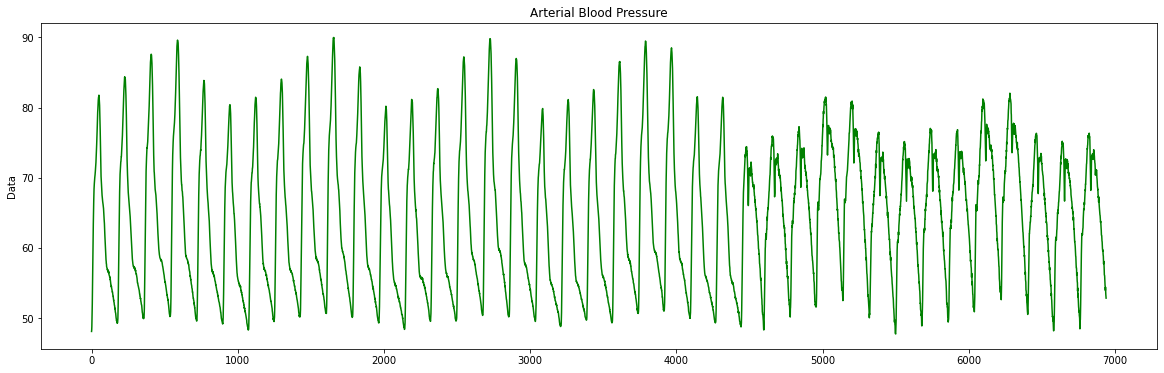

In [4]:
plt.figure(figsize=(20,6))
plt.plot(ts,'g')
plt.title('Arterial Blood Pressure')
plt.ylabel('Data')
plt.show()

### Discover and Visualize Snippets
For snippets discovery, there are two important parameters, namely *snippet_size* and *num_snippets*. *snippet_size* specifies how long the representative subsequence that we'd like to query, and *num_snippets* specifies how many representative subsequences are needed. Since we know beforehand that one cycle of the arterial blood pressure data is about 7.08 seconds and the time interval between data is approximately 0.04 seconds, here we set *snippet_size*  to 177. Besides, the dataset contains arterial blood pressure data collected from two different subjects, so the parameter *num_snippets*  is assigned to 2.

Actually, to set the snippet size, a priori knowledge of the periodicity of data is not necessary. If we are only able to make a rough estimate of the length of a period and use this estimate to set the *snippet_size*,  our snippet discovery algorithm still works well. In this example, to better visualize the top-2 snippets, we set *snippet_size* to the exact length of one cycle. In the next section, we'll show you how to estimate the snippet size and calculate time series snippets with the estimate.

** Snippet-1 **
Index: 2832
Fraction: 0.6385629436476894

** Snippet-2 **
Index: 4779
Fraction: 0.361726785455599



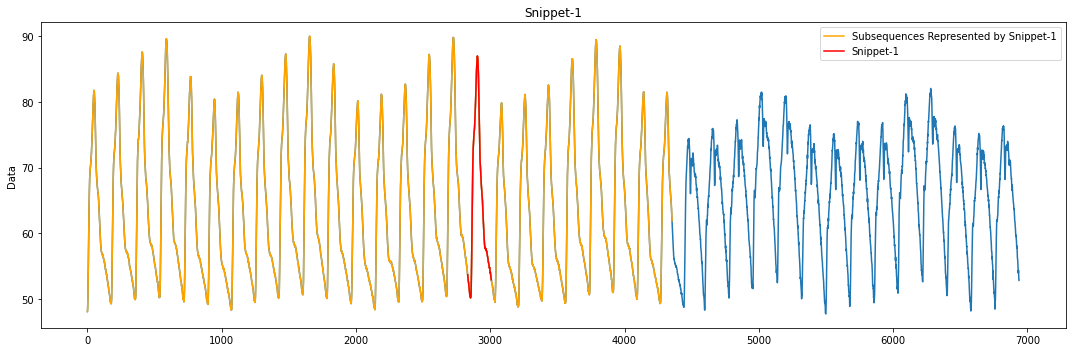

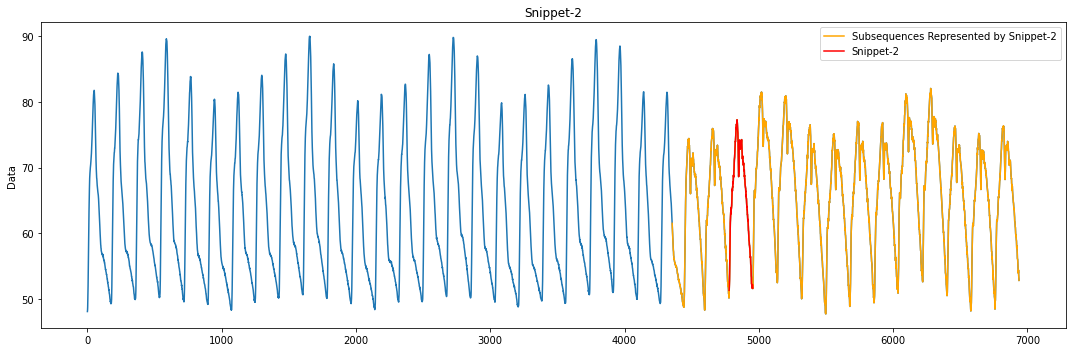

In [5]:
snippet_size = 177
num_snippets = 2

# Discover Snippets
snippets = mp.discover.snippets(ts, snippet_size, num_snippets)

# Print Snippet Metadata
for i in range(len(snippets)):
    print('** Snippet-' + str(i+1) + ' **')
    print('Index:', snippets[i]['index'])
    print('Fraction:', snippets[i]['fraction'])
    print()

# Visualize Snippets
plot_snippets(snippets, ts)
plt.show()

As you can see from the figures above, the MPA accurately identifies the patterns of blood pressure data from two different subjects. These patterns correspond to Snippet-1 and Snippet-2 and are marked in red in the figures. The time series subsequences represented/explained by Snippet-1 and Snippet-2 are marked in orange. Meanwhile, from the printed snippet metadata, the starting index of the first snippet is 2832, which falls in the range of pig-1's arterial blood pressure data; the second snippet starts at 4779, which is also in the range of pig-2's arterial blood pressure data. Also, we can learn from the snippet metadata that Snippet-1 can represent/explain approximately 63.9% of the data while Snippet-2 can represent/explain about 36.1% of the data, which is almost consistent with the ground truth.

## Analyze Synthetic Signal Dataset with MPA
The sample dataset in the previous section is relatively easy to work with, as it only has two distinct patterns and the data represented/explained by the same snippet are contiguous. This time, we try to find snippets in a more challenging dataset. In this sample dataset, there are three different patterns, and the distribution of these patterns is relatively dispersed. Let's see how to use our Matrix Profile API to address this challenge.

### Load Data

In [6]:
ts = np.loadtxt('SyntheticSignal.txt')

### <span id="VisualizeData2">Visualize Data</span>

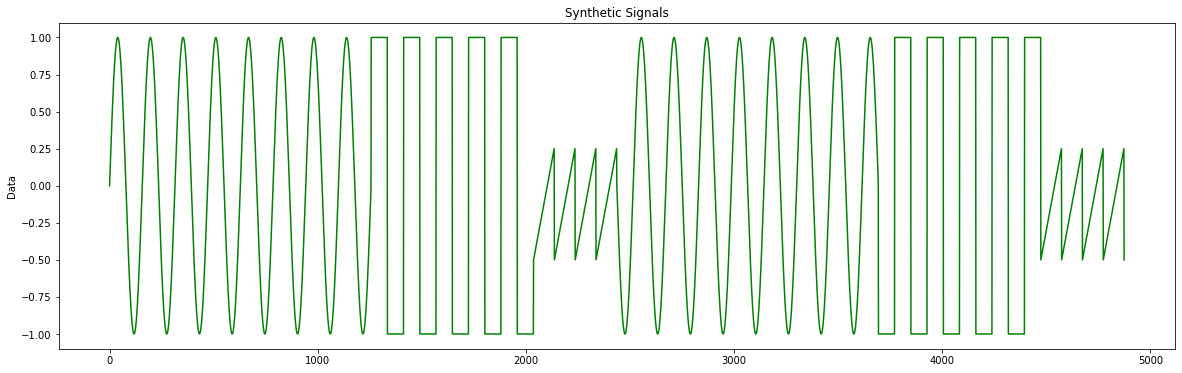

In [7]:
plt.figure(figsize=(20,6))
plt.plot(ts,'g')
plt.title('Synthetic Signals')
plt.ylabel('Data')
plt.show()

### Discover and Visualize Snippets

The following code extract illustrates how we generate the sine waves, which gives you a clue as to the setting of *snippet_size*.
>x = np.arange(0, 4\*np.pi, 0.01)  
ts = list(np.sin(4*x))

Because the trigonometric function model we introduce to generating sinusoidal signals is f(x) = sin (4x) and samples are taken every 0.01 unit time, the period length of the sine waves is T = 2π/4 × 100 ≈ 157. To show the effect of using the estimated value to calculate snippets, we round down the calculated period length and assign the *snippet_size* to 150. Of course, in addition to calculating the period length, there is a simpler way to set the *snippet_size*, that is, to infer the period length by observing the begin and end positions of a pattern. 

Furthermore, it's clear that there are three distinct patterns in the dataset, so the *snippet_num* is set to 3.

** Snippet-1 **
Index: 900
Fraction: 0.505625

** Snippet-2 **
Index: 1350
Fraction: 0.306875

** Snippet-3 **
Index: 2250
Fraction: 0.18791666666666668



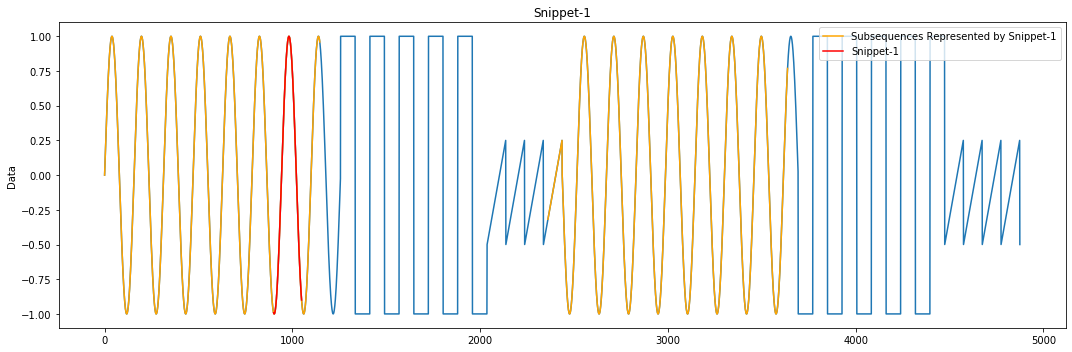

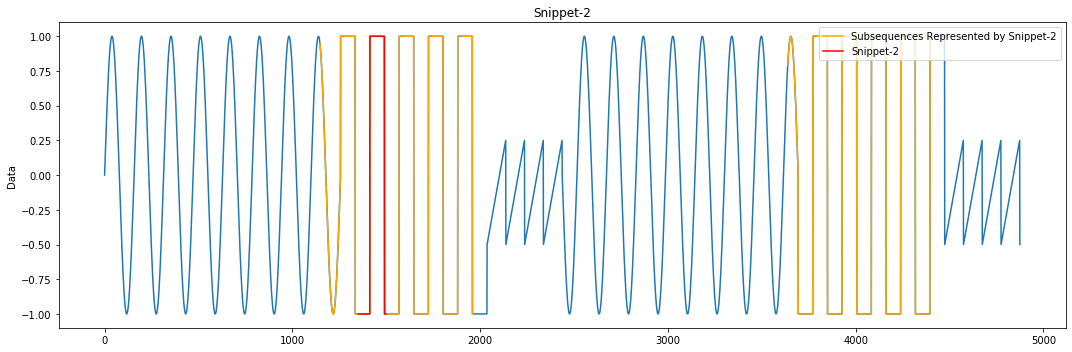

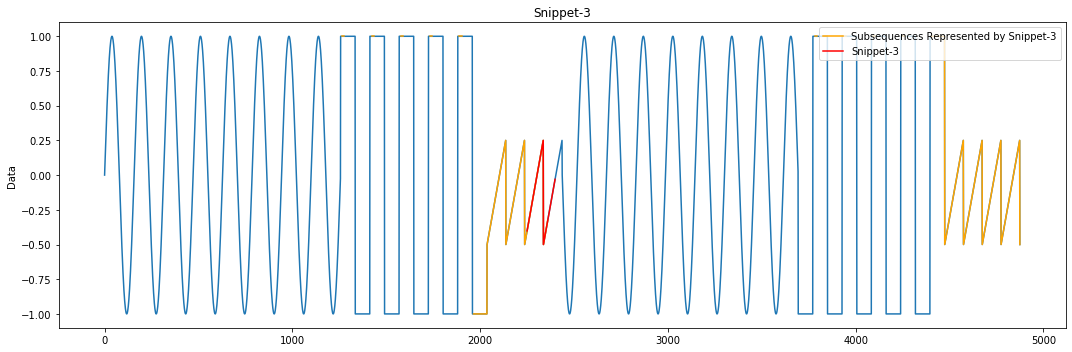

In [13]:
snippet_size = 150
snippet_num = 3

# Discover Snippets
snippets = mp.discover.snippets(ts,snippet_size,snippet_num)

# Print Snippet Metadata
for i in range(len(snippets)):
    print('** Snippet-' + str(i+1) + ' **')
    print('Index:', snippets[i]['index'])
    print('Fraction:', snippets[i]['fraction'])
    print()

# Visualize Snippets
plot_snippets(snippets, ts)
plt.show()

As can be seen from the figures above, the MPA can precisely identify three different waveforms, and each waveform is marked in red in the corresponding figure. Also, the results calculated by the estimated value are all in accordance with the facts: the sine wave is the largest part of the data set, so it's reasonable to recognize the sine wave pattern as the top-1 snippet; the square wave account for the second-largest fraction, and thus its pattern should correspond to the second snippet; as the sawtooth wave has the least proportion, it also makes sense to designate it as the third snippet.

What's more, in addition to the snippets, the MPA also discovers all subsequences similar or identical to the current snippets and highlights them in orange in the figures. These are what we store in the metadata "neighbors". According to the figures, the different waveforms in the data set are roughly separated out by the snippet metadata, which to some extent verifies the possibility of utilizing time series snippets to solve clustering-like problems.

## Reference
[[1]](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8588817) Imani, S., Madrid, F., Ding, W., Crouter, S., & Keogh, E. (2018, November). Matrix Profile XIII: Time Series Snippets: A New Primitive for Time Series Data Mining. In 2018 IEEE International Conference on Big Knowledge (ICBK) (pp. 382-389). IEEE.

[[2]](https://dl.acm.org/doi/pdf/10.5555/3122009.3176865) Guillame-Bert, M., & Dubrawski, A. (2017). Classification of time sequences using graphs of temporal constraints. The Journal of Machine Learning Research, 18(1), 4370-4403.

[[3]](https://commons.wikimedia.org/wiki/File:Waveforms.svg) File:Waveforms.svg. (n.d.). In *Wikimedia Commons*. Retrieved from https://commons.wikimedia.org/wiki/File:Waveforms.svg